In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import logging
import numpy as np
import py21cmfast as p21c
import math
from py21cmfast import (
    AstroParams,
    CosmoParams,
    FlagOptions,
    UserParams,
    determine_halo_list,
    initial_conditions,
    perturb_field,
    plotting
    )

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:49: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/_cfg.py:33: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [16]:
p21c.AstroParams?

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_data_from_h5(filename):

    with h5py.File(filename, "r") as hf:

        print("Datasets: ", list(hf.keys()))

        X = hf["X"][:]
        Y = hf["Ytrue"][:]
        Ypred = hf["Ypred"][:]
        redshifts = hf["redshifts"][:]

    return X, Y, Ypred, redshifts

results_file = '/Users/jacobkennedy/Desktop/PHYS_459/092021/sept_20_test_boxes/z8-9_HII-DIM-128_BOX-LEN-256_coeval_boxes_results.h5'

'''

X: The wedge-filtered coeval boxes
Y: The original coeval boxes, generated by 21cm Fast, BRIGHTNESS TEMPERATURE
Y_pred: The lightcones that the machine learning model predicts.
redshifts: The redshifts that the lightcones were generated at

'''

X, Y, Ypred, redshifts = load_data_from_h5(results_file)


print("X shape: ", X.shape)

Datasets:  ['X', 'Ypred', 'Ytrue', 'redshifts']
X shape:  (2, 128, 128, 128)


In [3]:
# Init cond for .h5 file

HII_DIM = 128
BOX_LEN = 128

init_cond = p21c.initial_conditions(
    user_params = {"HII_DIM": HII_DIM, "BOX_LEN": BOX_LEN}, 
    cosmo_params = p21c.CosmoParams(SIGMA_8 = 0.8), 
    random_seed = 42242)
    
redshift = 8.0

pt_box = perturb_field(
    redshift=redshift,
    init_boxes=init_cond,
    #user_params=user_params,
    #cosmo_params=cosmo_params,
    )

halos = determine_halo_list(
    redshift=redshift,
    init_boxes=init_cond,
    #user_params=user_params, 
    #cosmo_params=cosmo_params,
    #astro_params=astro_params,
    #flag_options=flag_options,
    regenerate=True,
    write=False,
    OPTIMIZE=False,
    )

list_halo_coords = halos.halo_coords

/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/inputs.py:485: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


/opt/anaconda3/envs/21cmfast/lib/python3.9/site-packages/py21cmfast/plotting.py:101: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(slc, origin="lower", cmap=cmap, norm=norm, **imshow_kw)


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='y-axis [Mpc]', ylabel='z-axis [Mpc]'>)

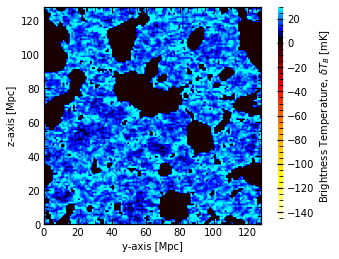

In [4]:
# We want to plot the recovered bubbles, with the masses overplotted on a colour scale
# corresponding to mass (redshift = 8)
ionized_box=p21c.ionize_box(perturbed_field = pt_box)
# We can check if the boxes from Jonathan are same as the ones from init_cond
brightness_temp=p21c.brightness_temperature(ionized_box=ionized_box, perturbed_field=pt_box)
p21c.plotting.coeval_sliceplot(brightness_temp, slice_index=0, slice_axis=0)

In [5]:
# get halo masses in the slice to plot onto, do not sort yet
halo_masses_slice = halos.halo_masses[halos.halo_coords[:,2]==0]
#sorted_halo_masses_slice = np.sort(halo_masses_slice)
#sorted_halo_masses_inds_slice = np.argsort(halo_masses_slice)
halo_coords_slice = halos.halo_coords[halos.halo_coords[:,2]==0]

#sorted_halo_coords_slice = halo_coords_slice[sorted_halo_masses_inds_slice]

In [6]:
# Convert halo_coords_slice into distance coords to plot overtop of bubble plot

def vox_to_dist(box_len, HII_dim, vox_coords):
    dim = HII_dim*3
    dist_coords = (box_len/dim)*vox_coords
    return dist_coords

dist_halo_coords_slice = vox_to_dist(BOX_LEN, HII_DIM, halo_coords_slice[:, :2])

# Note: Indexing of the coeval boxes is [z,y,x], and hence a slice-axis=-1 $\implies$ along z (slice of x-y plane), slice-axis=0 $\implies$ along x (slice of z-y plane), slice-axis=+1 $\implies$ along y (slice of z-x plane).

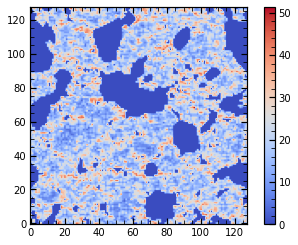

In [9]:
orig_coeval_box = Y[0]
orig_coeval_box_slice = orig_coeval_box[:,:,0]
#fig, ax = plt.subplots(figsize=[14, 8])
plt.imshow(orig_coeval_box_slice, cmap='coolwarm')#,  interpolation='nearest')
plt.gca().invert_yaxis()
#plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

Ionized bubbles are those with zero 21cm signal, so $\Delta T = 0$, hence these areas will appear white in binarized boxes, whilst neutral areas will be black (presence of 21cm signal). Ypred contains the normalized predicted data not yet binarized. Therefore, we will adopt the cutoff used in Gagnon-Hartman et al. 2021 of 0.9, to classify a box as ionized or neutral. Therefore, any voxel with a value $\geq 0.9$ will be mapped to 1.0, and hence be considered neutral. Conversely, any voxel $<0.9$ will be mapped to 0, and hence be classified as fully ionized.

In [10]:
# Plot the binarized data after applying 0.9 cutoff, do so for tranverse slice at z=0

cutoff = 0.9
y_0 = Ypred[0]
slice_binarized_pred = y_0[:,:,0] # z = 0
super_threshold_indices = (slice_binarized_pred >= cutoff) # map to 1
sub_threshold_indices = (slice_binarized_pred < cutoff) # map to 0
slice_binarized_pred[super_threshold_indices] = 1 # 
slice_binarized_pred[sub_threshold_indices] = 0

Text(0.5, 0, 'y-axis [Mpc]')

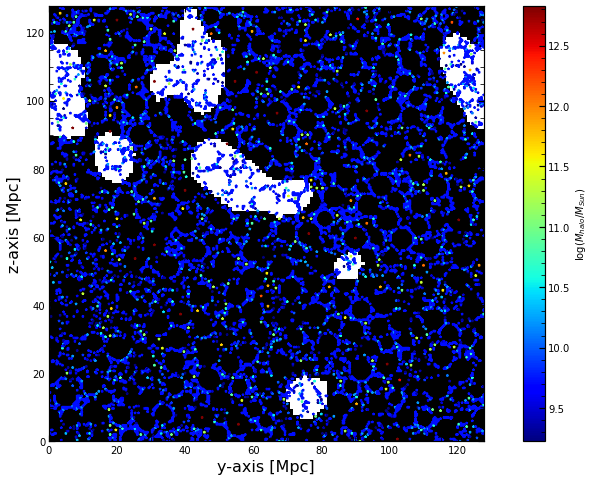

In [11]:
fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(slice_binarized_pred, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
#plt.show()
#fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles.jpeg')

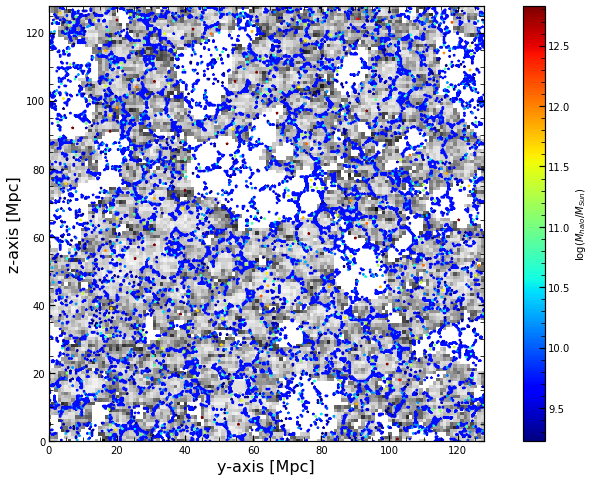

In [18]:


fig, ax = plt.subplots(figsize=[14, 8])
ax.imshow(orig_coeval_box_slice, cmap='Greys')#,  interpolation='nearest')
# for x=x_coord, y=y_coord, c=mass, and cmap will put gradient of masses
plt.gca().invert_yaxis()
im = ax.scatter(x=dist_halo_coords_slice[:,0], y=dist_halo_coords_slice[:,1], 
           marker='*', s=5.0, c=np.log10(halo_masses_slice), cmap='jet')
fig.colorbar(im, label='log($M_{halo}/M_{Sun}$)', ax=ax)
ax.set_xlim(0, 127.6666666)
ax.set_ylim(0, 127.6666666)
ax.set_ylabel('z-axis [Mpc]', fontsize=16)
ax.set_xlabel('y-axis [Mpc]', fontsize=16)
fig.savefig('/Users/jacobkennedy/Desktop/PHYS_459/color_coded_masses_over_bubbles2.jpeg')

In [102]:
print(slice_binarized_pred)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [105]:
a = np.array([0.01, 0.9, 0.91, 0.5, 0.001])
super_threshold_indices = (a >= 0.9)
sub_threshold_indices = (a < 0.9)
a[super_threshold_indices] = 1
a[sub_threshold_indices] = 0

In [106]:
print(a)

[0. 1. 1. 0. 0.]
